In [1]:
import sys
import gc
import os
from tqdm import tqdm
import time

import numpy as np
import pickle
import scipy.io as sio
from scipy.io import loadmat
import matplotlib.pyplot as plt
import cv2
import torchvision.transforms as transforms
from PIL import Image


# Pytorch 1.9
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions

# Pytorch3d
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    TexturesVertex,
    blending
)

import open3d as o3d

# facenet-pytorch 2.5.2
from facenet_pytorch import MTCNN, InceptionResnetV1

# face-alignment 1.3.4
import face_alignment

#######################################
## Setup PyTorch
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
    print('CUDA is available. Device: ', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('CUDA is NOT available. Use CPU instead.')
    
    

c:\users\yanpe\appdata\local\programs\python\python36\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
c:\users\yanpe\appdata\local\programs\python\python36\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
c:\users\yanpe\appdata\local\programs\python\python36\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


CUDA is available. Device:  NVIDIA GeForce RTX 3070


In [10]:
shape_path = '../../datasets/FFHQ/raw_bfm_shape/'
file_indices = []
for fname in os.listdir(shape_path):
    if fname.endswith('.npy'):
        file_indices.append(fname.split('.')[0])
shape_path += '{}.npy'

ffhq_meanshape = np.load('../ffhq_meanshape.npy')


In [5]:
"""
 1: face skin
 2: eye brows
 3: eyes
 4: nose
 5: upper lip
 6: lower lip
"""
label_map = {
    'skin': 1,
    'eye_brow': 2,
    'eye': 3,
    'nose': 4,
    'u_lip': 5,
    'l_lip': 6
}

## Load the face parsing labels (per-vertex)
vert_labels = np.load('../../BFM/bfm_vertex_labels.npy')
print(set(vert_labels))


## Load the BFM model
import pickle
with open('../../BFM/bfm09.pkl', 'rb') as f:
    bfm = pickle.load(f)
print('BFM model loaded\n')

## Triangal Facets
Faces = bfm['tri'] - 1 ## -1 is critical !!!

# find the vertices of part
part_vertices = {
    'S_overall':[],
    #'S_rest':[],
    'S_eyebrows':[],
    'S_eyes':[],
    'S_llip':[],
    'S_nose':[],
    'S_ulip':[]
}
for idx in range(len(vert_labels)):
    part_vertices['S_overall'].append(idx)
    if vert_labels[idx] in [label_map['eye_brow']]:
        part_vertices['S_eyebrows'].append(idx)
    if vert_labels[idx] in [label_map['eye']]:
        part_vertices['S_eyes'].append(idx)
    if vert_labels[idx] in [label_map['l_lip']]:
        part_vertices['S_llip'].append(idx)
    if vert_labels[idx] in [label_map['u_lip']]:
        part_vertices['S_ulip'].append(idx)
    if vert_labels[idx] in [label_map['nose']]:
        part_vertices['S_nose'].append(idx)
    
for key in part_vertices:
    part_vertices[key] = np.array(part_vertices[key])
    print(key, ' n_vert: ', len(part_vertices[key]))

{1, 2, 3, 4, 5, 6}
BFM model loaded

S_overall  n_vert:  35709
S_eyebrows  n_vert:  444
S_eyes  n_vert:  586
S_llip  n_vert:  309
S_nose  n_vert:  1711
S_ulip  n_vert:  576


In [6]:
import math
bfm_68_landmarks = bfm['keypoints'][0] # mapping between 68 landmarks and their bfm vertices

def landmark_2_vertex(landmark_idx):
    """convert landmark (1~68) to corresponding bfm vertex index"""
    return bfm_68_landmarks[landmark_idx-1]

def bounding_box_height(shape, vertices):
    y_max = np.max(shape[0, vertices, 1])
    y_min = np.min(shape[0, vertices, 1])
    height = y_max - y_min
    return height

def bounding_box_width(shape, vertices):
    x_max = np.max(shape[0, vertices, 0])
    x_min = np.min(shape[0, vertices, 0])
    width = x_max - x_min
    return width


def euclidean_distance(shape, v1, v2):
    p1 = shape[0, v1, :]
    p2 = shape[0, v2, :]
    return l2_distance(p1, p2)

def l2_distance(p1, p2):
    pp = np.square(p1 - p2)    
    return math.sqrt(pp[0] + pp[1] + pp[2])
    

def y_axis_distance(shape, v1, v2):
    p1_y = shape[0, v1, 1]
    p2_y = shape[0, v2, 1]
    return abs(p1_y - p2_y)

def x_axis_distance(shape, v1, v2):
    p1_x = shape[0, v1, 0]
    p2_x = shape[0, v2, 0]
    return abs(p1_x - p2_x)




def maximum_facial_width(ffhq_meanshape, shape):
    distance_mean = bounding_box_width(ffhq_meanshape, part_vertices['S_overall'])
    distance = bounding_box_width(shape, part_vertices['S_overall'])
    return distance - distance_mean 
    
def madibular_width(ffhq_meanshape, shape):
    v1 = 256
    v2 = 22238
    distance_mean = x_axis_distance(ffhq_meanshape, v1, v2)
    distance = x_axis_distance(shape, v1, v2)
    return distance - distance_mean 

def upper_facial_depth(ffhq_meanshape, shape):
    v1 = 8132
    distance_mean = ffhq_meanshape[0, v1, 2]
    distance = shape[0, v1, 2]
    return distance - distance_mean 

def middle_facial_depth(ffhq_meanshape, shape):
    v1 = 8205
    distance_mean = ffhq_meanshape[0, v1, 2]
    distance = shape[0, v1, 2]
    return distance - distance_mean 

def lower_facial_depth(ffhq_meanshape, shape):
    v1 = 33838
    distance_mean = ffhq_meanshape[0, v1, 2]
    distance = shape[0, v1, 2]
    return distance - distance_mean 

def facial_height(ffhq_meanshape, shape):
    v1 = 8132
    v2 = 33838
    distance_mean = y_axis_distance(ffhq_meanshape, v1, v2)
    distance = y_axis_distance(shape, v1, v2)
    return distance - distance_mean 

def upper_facial_height(ffhq_meanshape, shape):
    v1 = 8132
    v2 = 8229
    distance_mean = y_axis_distance(ffhq_meanshape, v1, v2)
    distance = y_axis_distance(shape, v1, v2)
    return distance - distance_mean 

def lower_facial_height(ffhq_meanshape, shape):
    v1 = 8205
    v2 = 33838
    distance_mean = y_axis_distance(ffhq_meanshape, v1, v2)
    distance = y_axis_distance(shape, v1, v2)
    return distance - distance_mean 

    



In [12]:
"""
Measure the shapes and record in a matrix
"""
measurements = np.zeros([len(file_indices), 8])

for i in tqdm(range(len(file_indices))):
    file_idx = file_indices[i]
    shape = np.load(shape_path.format(file_idx))
    
    measurements[i, 0] = maximum_facial_width(ffhq_meanshape, shape)
    measurements[i, 1] = madibular_width(ffhq_meanshape, shape)
    measurements[i, 2] = upper_facial_depth(ffhq_meanshape, shape)
    measurements[i, 3] = middle_facial_depth(ffhq_meanshape, shape)
    measurements[i, 4] = lower_facial_depth(ffhq_meanshape, shape)
    measurements[i, 5] = facial_height(ffhq_meanshape, shape)
    measurements[i, 6] = upper_facial_height(ffhq_meanshape, shape)
    measurements[i, 7] = lower_facial_height(ffhq_meanshape, shape)
  



100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 294.12it/s]


   maximum_facial_width  madibular_width  upper_facial_depth  \
0              0.011478        -0.036301           -0.024576   
1              0.015947         0.007813            0.014310   
2              0.036301         0.032041           -0.026374   
3             -0.044098        -0.045500           -0.027022   
4             -0.032800        -0.066198            0.013080   

   middle_facial_depth  lower_facial_depth  facial_height  \
0            -0.053882           -0.075040      -0.203673   
1             0.020969            0.031634      -0.014400   
2            -0.015508           -0.013807      -0.067644   
3            -0.067560           -0.103204      -0.114380   
4             0.023407           -0.026652       0.024795   

   upper_facial_height  lower_facial_height  
0            -0.116306            -0.093901  
1            -0.021252            -0.022102  
2            -0.020302            -0.039513  
3            -0.055742            -0.045530  
4             0.04

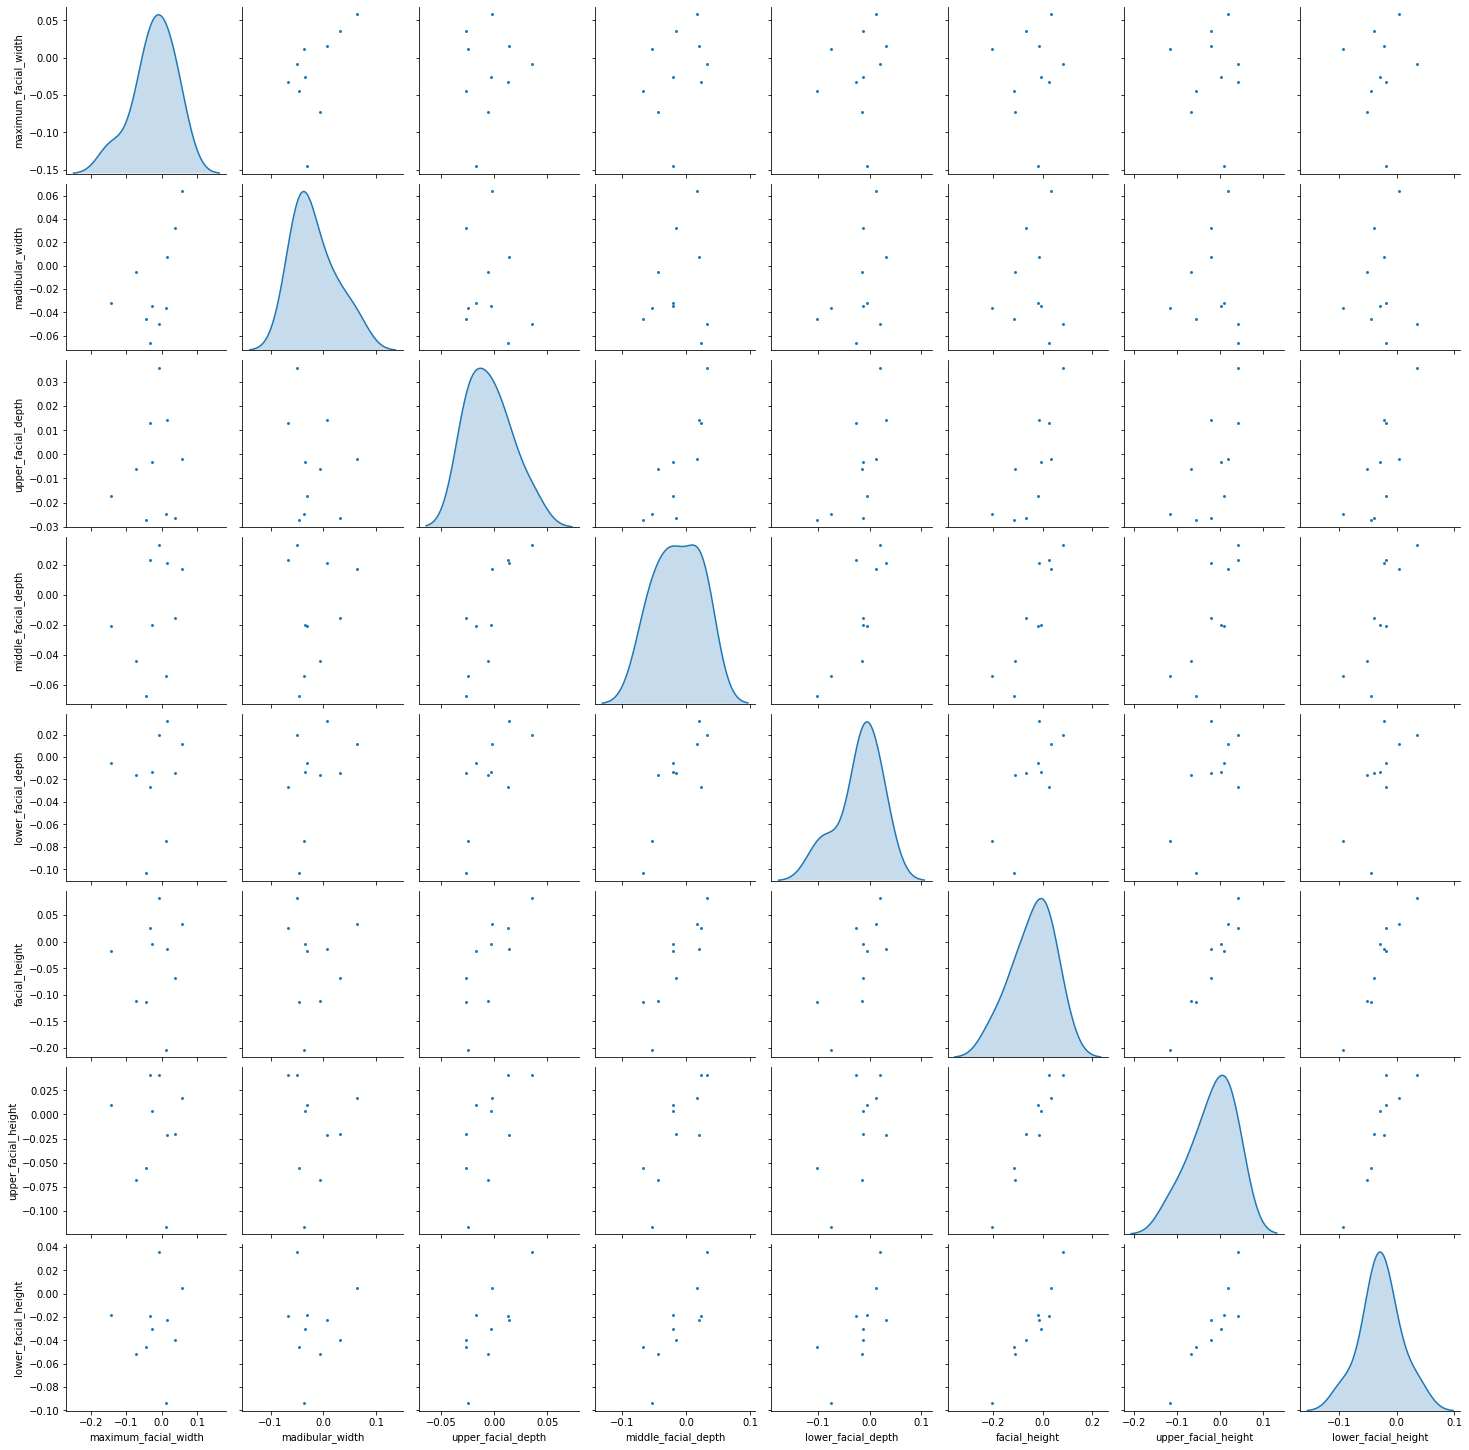

In [13]:
"""
Visualize the data
"""
import seaborn as sns
import pandas as pd

measurement_names = [
    'maximum_facial_width',
    'madibular_width',
    'upper_facial_depth',
    'middle_facial_depth',
    'lower_facial_depth',
    'facial_height',
    'upper_facial_height',
    'lower_facial_height'
]
    


d = {
    measurement_names[0]: measurements[:, 0],
    measurement_names[1]: measurements[:, 1],
    measurement_names[2]: measurements[:, 2],
    measurement_names[3]: measurements[:, 3],
    measurement_names[4]: measurements[:, 4],
    measurement_names[5]: measurements[:, 5],
    measurement_names[6]: measurements[:, 6],
    measurement_names[7]: measurements[:, 7],
}

df = pd.DataFrame(data=d)
print(df.head())

_ = sns.pairplot(df, 
                 plot_kws=dict(marker=".", linewidth=0.01), 
                 diag_kind="kde")



In [9]:
""" Save the data matrix """
try:
    os.mkdir('./cache/measurements/')
except:
    print('folder exists, please ignore')
    
#np.save('./cache/measurements/{}.npy'.format('S_overall'), measurements)